# Understanding KL-Divergence

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

### Goals:



#### G1: Given probability distributions $p$ and $q$, find the divergence (measure of similarity) between them

Let us first look at G1. Look at the illustration below. We have a normal distribution $p$ and two other normal distributions $q_1$ and $q_2$. Which of $q_1$ and $q_2$, would we consider closer to $p$? $q_2$, right? 

![](dkl.png)

To understand the notion of similarity, we use a metric called the KL-divergence given as $D_{KL}(a || b)$ where $a$ and $b$ are the two distributions. 

For G1, we can say $q_2$ is closer to $p$ compared to $q_1$ as:

$D_{KL}(q_2 || p) \lt D_{KL}(q_1 || p)$

For the above example, we have the values as $D_{KL}(q_2|| p) = 0.07$ and $D_{KL}(q_1|| p)= 0.35$

#### G2: assuming $p$ to be fixed, can we find optimum parameters of $q$ to make it as close as possible to $p$

The following GIF shows the process of finding the optimum set of parameters for a normal distribution $q$ so that it becomes as close as possible to $p$. This is equivalent of minimizing $D_{KL}(q || p)$


![](kl_qp.gif)

### Basic Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow_probability as tfp
import pandas as pd
tfd = tfp.distributions
tfl = tfp.layers
tfb = tfp.bijectors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback
sns.reset_defaults()
sns.set_context(context='talk',font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Creating distributions

#### Creating $p\sim\mathcal{N}(1.00, 4.00)$

In [2]:
p = tfd.Normal(1, 4)

2022-01-29 15:03:31.935315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-29 15:03:31.935395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


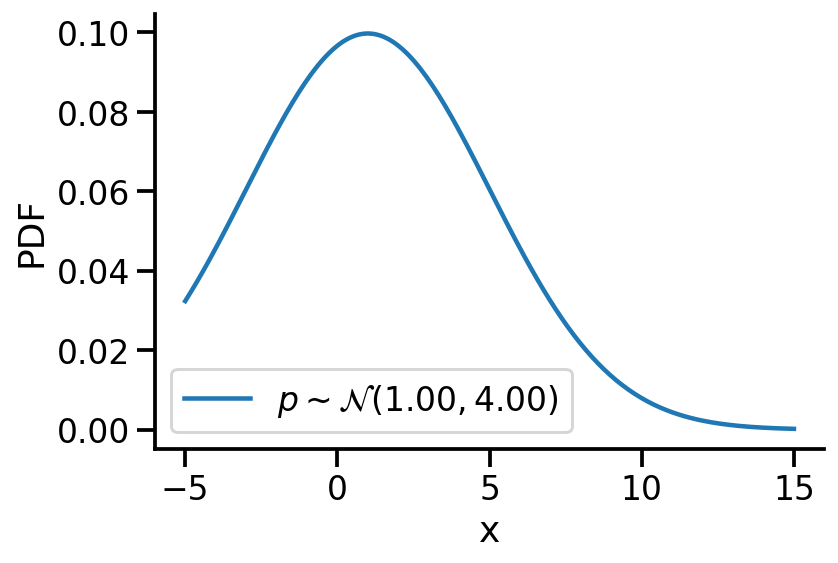

In [3]:
z_values = tf.linspace(-5, 15, 200)
z_values = tf.cast(z_values, tf.float32)
prob_values_p = p.prob(z_values)
plt.plot(z_values, prob_values_p, label=r'$p\sim\mathcal{N}(1.00, 4.00)$')
sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF");

#### Creating $q\sim\mathcal{N}(loc, scale)$

In [4]:
def create_q(loc, scale):
    return tfd.Normal(loc, scale)

#### Generating a few qs for different location and scale value

In [5]:
q =  {}
q[(0, 1)] = create_q(0., 1.)

for loc in [0, 1]:
    for scale in [1, 2]:
        q[(loc, scale)] = create_q(float(loc), float(scale))

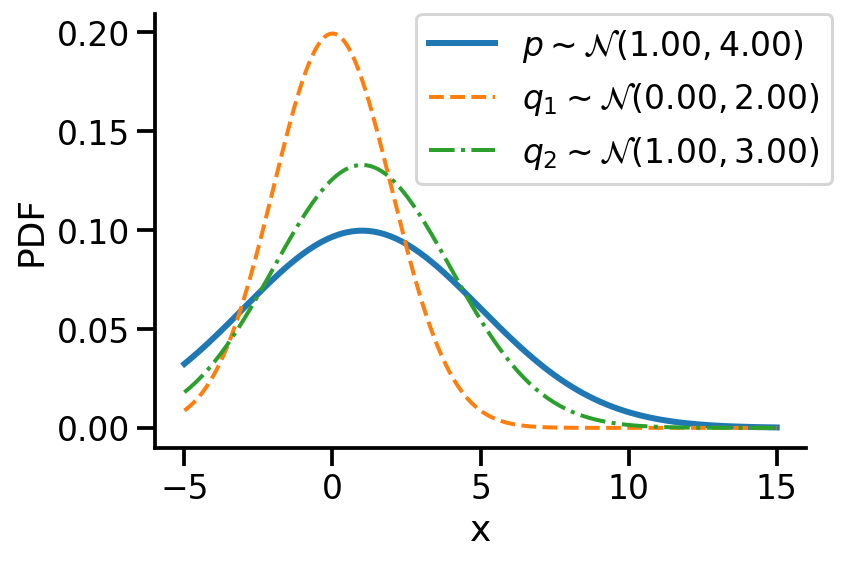

In [6]:
plt.plot(z_values, prob_values_p, label=r'$p\sim\mathcal{N}(1.00, 4.00)$', lw=3)
plt.plot(z_values, create_q(0., 2.).prob(z_values), 
         label=r'$q_1\sim\mathcal{N}(0.00, 2.00)$', lw=2, linestyle='--')
plt.plot(z_values, create_q(1., 3.).prob(z_values),
         label=r'$q_2\sim\mathcal{N}(1.00, 3.00)$', lw=2, linestyle='-.')

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.xlabel("x")
plt.ylabel("PDF")
sns.despine()
plt.tight_layout()
plt.savefig("dkl.png", dpi=200, )

In [7]:
#### Computing KL-divergence

q_0_2_dkl = tfd.kl_divergence(create_q(0., 2.), p)
q_1_3_dkl = tfd.kl_divergence(create_q(1., 3.), p)

print(f"D_KL (q(0, 2)||p) = {q_0_2_dkl:0.2f}")
print(f"D_KL (q(1, 3)||p) = {q_1_3_dkl:0.2f}")

D_KL (q(0, 2)||p) = 0.35
D_KL (q(1, 3)||p) = 0.07


As mentioned earlier, clearly, $q_2\sim\mathcal{N}(1.00, 3.00)$ seems closer to $p$

#### Optimizing the KL-divergence between q and p

We could create a grid of (loc, scale) pairs and find the best, as shown below.

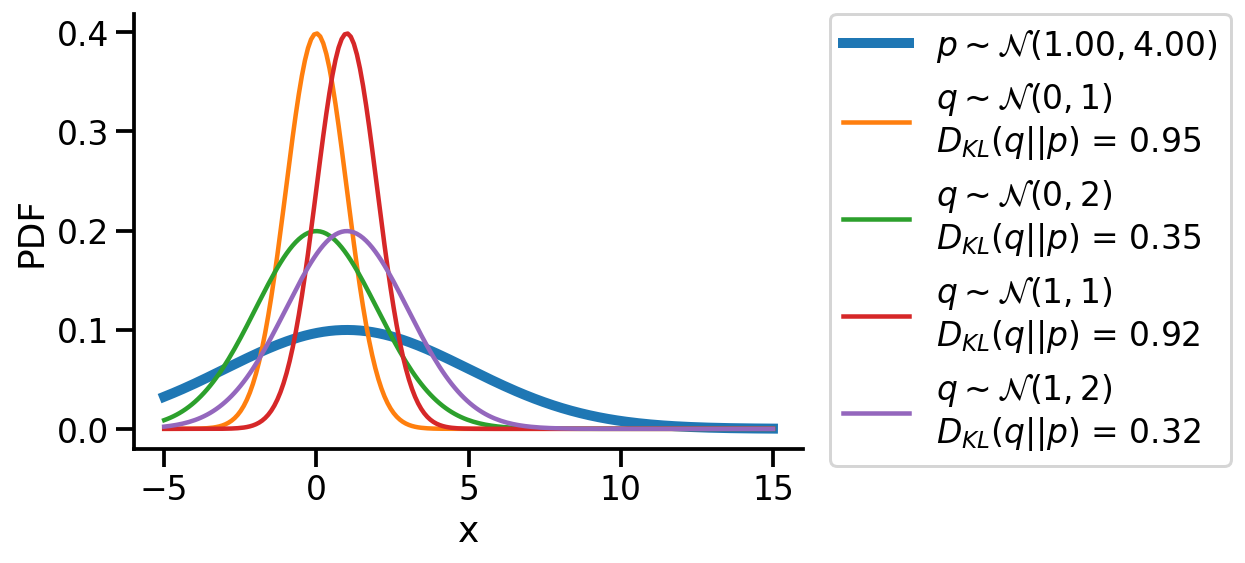

In [8]:
plt.plot(z_values, prob_values_p, label=r'$p\sim\mathcal{N}(1.00, 4.00)$', lw=5)


for loc in [0, 1]:
    for scale in [1, 2]:
        q_d = q[(loc, scale)]
        kl_d = tfd.kl_divergence(q[(loc, scale)], p)
        plt.plot(z_values, q_d.prob(z_values), label = fr'$q\sim\mathcal{{N}}({loc}, {scale})$'
                 +'\n'+rf'$D_{{KL}}(q||p)$ = {kl_d:0.2f}')
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.xlabel("x")
plt.ylabel("PDF")
sns.despine()

Or, we could use continuous optimization to find the best loc and scale parameters for q.

In [9]:
to_train_q = tfd.Normal(loc = tf.Variable(-1., name='loc'),
                        scale = tfp.util.TransformedVariable(1., bijector=tfb.Exp(), name='scale'))

In [10]:
to_train_q.trainable_variables

2022-01-29 15:03:32.580161: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=-1.0>,
 <tf.Variable 'scale:0' shape=() dtype=float32, numpy=0.0>)

In [11]:
@tf.function
def loss_and_grads(q_dist):
    with tf.GradientTape() as tape:
        loss = tfd.kl_divergence(q_dist, p)
    return loss, tape.gradient(loss, q_dist.trainable_variables)

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

for i in range(500):
    loss, grads = loss_and_grads(to_train_q)
    optimizer.apply_gradients(zip(grads, to_train_q.trainable_variables))

2022-01-29 15:03:32.644148: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-29 15:03:32.644204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [13]:
to_train_q.loc,to_train_q.scale

(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=0.9887372>,
 <TransformedVariable: name=scale, dtype=float32, shape=[], fn="exp", numpy=4.0>)

After training, we are able to recover the scale and loc very close to that of $p$

#### Animation!

In [14]:
from matplotlib import animation
fig = plt.figure(tight_layout=True, figsize=(8, 4))
ax = fig.gca()

to_train_q = tfd.Normal(loc = tf.Variable(5., name='loc'),
                        scale = tfp.util.TransformedVariable(0.1, bijector=tfb.Exp(), name='scale'))

def animate(i):
    ax.clear()
    ax.plot(z_values, prob_values_p, label=r'$p\sim\mathcal{N}(1.00, 4.00)$', lw=5)
    loss, grads = loss_and_grads(to_train_q)
    optimizer.apply_gradients(zip(grads, to_train_q.trainable_variables))
    loc = to_train_q.loc.numpy()
    scale = to_train_q.scale.numpy()
    
    ax.plot(z_values, to_train_q.prob(z_values), label=fr"$q\sim \mathcal{{N}}({loc:0.2f}, {scale:0.2f})$")
    d_kl = tfd.kl_divergence(to_train_q, p)
    
    ax.set_title(fr"Iteration: {i}, $D_{{KL}}(q||p)$: {d_kl:0.2f}")
    ax.legend(bbox_to_anchor=(1.1,1), borderaxespad=0)
    ax.set_ylim((0, 1))
    ax.set_xlim((-5, 15))


    ax.set_xlabel("x")
    ax.set_ylabel("PDF")
    sns.despine()
    
ani = animation.FuncAnimation(fig, animate, frames=150)
plt.close()


In [15]:
ani.save('kl_qp.gif', writer='imagemagick', fps=15, dpi=100)

<Figure size 432x288 with 0 Axes>

![](kl_qp.gif)

#### What if p and q are from different families?

Let us rework our example with `p` coming from `Student-T` distribution and `q` being Normal.

In [16]:
p_s = tfd.StudentT(df = 3, loc = 3, scale=5)
p_s

<tfp.distributions.StudentT 'StudentT' batch_shape=[] event_shape=[] dtype=float32>

Let us create two Normal distributions q_1 and q_2 and plot them to see which looks closer to p_s.

In [22]:
q_1 = create_q(3, 1)
q_2 = create_q(3, 4.5)

prob_values_p_s = p_s.prob(z_values)
prob_values_q_1 = q_1.prob(z_values)
prob_values_q_2 = q_2.prob(z_values)

plt.plot(z_values, prob_values_p_s, label=r'Student-T')
plt.plot(z_values, prob_values_q_1, label=r'$q_1\sim\mathcal{N} (3, 1.0)$')
plt.plot(z_values, prob_values_q_2, label=r'$q_2\sim\mathcal{N} (3, 4.5)$')

sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF");


In [24]:
tfd.kl_divergence(q_1, p_s)

NotImplementedError: No KL(distribution_a || distribution_b) registered for distribution_a type Normal and distribution_b type StudentT

As we see above, we can not compute the KL divergence directly.

In [26]:
def kl_via_sampling(q, p, n_samples = 100000):
    # Get samples from q
    sample_set = q.sample(n_samples)
    # Use the definition of KL-divergence
    return tf.reduce_mean(q.log_prob (sample_set) - p.log_prob(sample_set))
    #return tf.reduce_mean(tf.math.log (to_train_q.prob (sample_set) / p_s.prob(sample_set)))

In [28]:
kl_via_sampling(q_1, p_s), kl_via_sampling(q_2, p_s)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.2136024>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.10013302>)

As we can see from KL divergence calculations, `q_2`

References


- https://www.youtube.com/watch?v=HUsznqt2V5I
- https://www.youtube.com/watch?v=x9StQ8RZ0ag&list=PLISXH-iEM4JlFsAp7trKCWyxeO3M70QyJ&index=9
- https://colab.research.google.com/github/goodboychan/goodboychan.github.io/blob/main/_notebooks/2021-09-13-02-Minimizing-KL-Divergence.ipynb#scrollTo=gd_ev8ceII8q
